In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial


In [78]:
def linear_Z(A,theta1,t_max,dt,seed):
    np.random.seed(seed)
    # 時間パラメータ
    N = int(t_max / dt)  # ステップ数

    # ブラウン運動のサンプルパスを生成
    dW = norm.rvs(scale=np.sqrt(dt), size=N)
    W = np.cumsum(dW)

    # 確率過程Z_tの計算
    Z_t = np.zeros((2, N+1))  # 結果を格納する配列
    integrand = np.zeros((2, N+1))  # 積分項を格納する配列

    for i in range(1, N+1):
        t = i * dt
        integrand[:, i] = expm(-A * t) @ np.array([theta1, 0]) * dW[i-1]
        Z_t[:, i] = expm(A * t) @ np.sum(integrand[:, :i+1], axis=1)

    return Z_t

In [79]:
A = np.array([[-1, -1], [1, 0]])
theta1 = 1
t_max = 100
dt = 0.01
seed = 0
N = int(t_max / dt)  # ステップ数

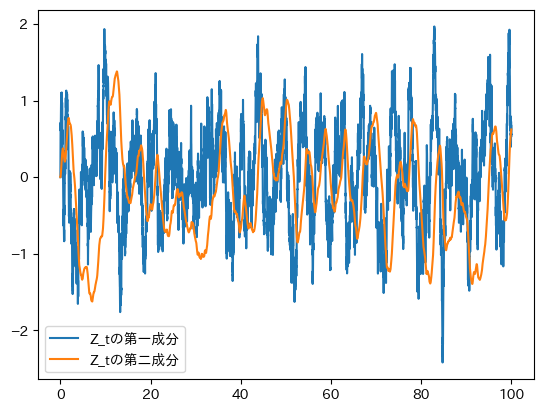

In [80]:
Z_t = linear_Z(A,theta1,t_max,dt,seed)
plt.plot(np.linspace(0, t_max, N+1), Z_t[0, :], label='Z_tの第一成分')
plt.plot(np.linspace(0, t_max, N+1), Z_t[1, :], label='Z_tの第二成分')
plt.legend()
plt.show()


In [23]:
def compute_a(theta1, theta21,theta22, theta3, k0):
    a = {}
    a[0] = 1
    a[-1] = 0
    for k in range(1, k0+1):
        a[k] = -theta21 * a[k-1]  - theta22 *theta3 * a[k-2]
    return a
def compute_s(a,theta1, theta21,theta22, theta3, k0):
    s = {}
    # aの計算
    # 各成分の計算
  
    for m in range(k0 + 1):
        mat11 = 0
        mat12 = 0
        mat22 = 0
        for k in range(min(m+1, k0)):
            l = m - k
            
            # 1,1成分の計算
            mat11 += theta1**2 * scipy.special.comb(m,k) *a[k] * a[l]/np.math.factorial(m+1) 
            
            # 1,2成分の計算
            mat12 += theta1**2 * theta3 * scipy.special.comb(m+1,k) *a[k] * a[l]/np.math.factorial(m+2)
            
            # 2,2成分の計算
            mat22 += theta3**2 * theta1**2 * scipy.special.comb(m+2,k+1) *a[k] * a[l]/np.math.factorial(m+3)
        s[m] = np.array([[mat11, mat12], [mat12, mat22]])
    return s

In [40]:
import numpy as np
from math import factorial

def calculate_d_e(s):
    d = {k: np.zeros_like(s[0]) for k in s.keys()}
    e = {k: 0 for k in s.keys()}
    k0 = max(s.keys())
    d[0] = np.linalg.inv(s[0])
    for m in range(1, k0+1):
        for p in range(m):
            for q in range(m):
                if p + q > m-1:
                    continue
                else:
                    r = m - p - q - 1
                    d[m] += factorial(m-1)/(factorial(p)*factorial(q)*factorial(r)) * np.dot(np.dot(d[p], s[q+1]), d[r])
    e[0] = np.log(np.linalg.det(s[0]))
    for m in range(1, k0+1):
        for p in range(m):
            q = m - p -1
            e[m] += - factorial(m)/factorial(p) * np.trace(np.dot(d[p+1], s[q]))
    return d, e


In [37]:
def D(a,x,y,x_,y_,theta1, theta21,theta22, theta3, k0,h):
    def f(x_,y_):
        f = 0
        for k in range(1,k0+1):
            f += (a[k] * x_   - theta22 * a[k-1] *y_) * h**k/np.math.factorial(k)
        return f
    def g(x_,y_):
        g = 0
        for k in range(1,k0+2):
            g += theta3*(a[k-1] * x_   - theta22 * a[k-2] *y_) * h**k/np.math.factorial(k)
        return g
    Dx = h**(-1/2) *(x - x_ - f(x_,y_))
    Dy = h**(-3/2) *(y - y_ - g(x_,y_))
    return np.array([Dx,Dy])

In [33]:
D(compute_a(1,1,1,1,2),[1,1],[0,0],1, 1,1,1, 2,0.1)

array([ 3.16227766, 31.6227766 ])

In [45]:
def QL(X,Y,theta1,theta21,theta22,theta3,k0,h):
    a = compute_a(theta1,theta21,theta22,theta3,k0)
    s = compute_s(a,theta1,theta21,theta22,theta3,k0)
    d, e = calculate_d_e(s)
    Q = 0
    for i in range(1,len(X)):
        for k in range(0,k0+1):
            D_ = D(a,X[i],Y[i],X[i-1],Y[i-1],theta1,theta21,theta22,theta3,k0,h)
            Q += - h**k *( np.trace(d[k]@np.outer(D_,D_)) + e[k])
    return Q

In [85]:
h = 0.01
X = Z_t[0,::int(h/dt)]
Y = Z_t[1,::int(h/dt)]

In [83]:
def mokutekikannsuu(theta):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    k0 = 10
    h = dt
    return -QL(X,Y,theta1,theta21,theta22,theta3,k0,h)

In [86]:
bounds = scipy.optimize.Bounds([0.1,0.1,0.1,0.1],[2,2,2,2])
scipy.optimize.minimize(mokutekikannsuu,[0.5,0.5,0.5,0.5],bounds = bounds)

In [65]:
mokutekikannsuu([1,1,1,1])

-4951.462277753048